# Predicting NBA Game Scores using Machine Learning

The provided Python code unfolds a comprehensive process to develop a robust multivariate regression model, tailored specifically for predicting final scores of both home and away teams in basketball matches. The journey can be summarized as follows:

1. **Data Gathering:**
   - Team statistics for home and away matches are collected through an API, creating a foundation for subsequent analysis.
   - Player statistics are fetched, processed, and aggregated to provide a comprehensive dataset for training and testing.

2. **Feature Engineering and Processing:**
   - Team stats are processed, yielding crucial metrics such as win rates, average points scored, and points allowed for both home and away teams.
   - Player stats are further processed, employing functions for data cleanup and calculating averaged player statistics.

3. **Injury Handling and Data Weighting:**
   - Injured players are identified and excluded to ensure the accuracy of predictions.
   - Player stats are weighted by playtime, enhancing the representation of the team's overall performance.

4. **Train/Test Data Generation:**
   - The code offers an optional step to generate train/test data for model learning, involving extensive preprocessing and the removal of injured players.

5. **Data Aggregation and Backup:**
   - The current match data is appended to a DataFrame (`rolling_train_test_df`) and an Excel sheet, facilitating randomized training and testing in future iterations.
   - Match pairs are combined into single rows, streamlining the dataset for modeling.

6. **Multivariate Regression Model:**
   - The model employs a Random Forest Regressor fine-tuned through hyperparameter tuning and feature engineering.
   - Despite the logistical challenge of using distinct hyperparameters for home and away scores, the model demonstrates exceptional accuracy during training.

7. **Evaluation and Presentation:**
   - Model predictions are evaluated using industry-standard metrics, including Mean Squared Error (MSE) and R-squared.
   - The actual and predicted scores are presented in a DataFrame (`actual_predicted_df`), allowing for a detailed comparison.

This code encapsulates a holistic methodology, spanning data collection, processing, and modeling, to empower accurate predictions of basketball match outcomes. Despite the constraints in hyperparameter tuning, the model showcases remarkable accuracy, emphasizing its potential for real-world applications.

In [9]:
# libraries
import numpy as np
import pandas as pd
import http.client
import json
import random
import seaborn as sns
import matplotlib.pyplot as plt

# ML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor

#### Team Name and ID Reference

In [10]:
nba_teams = pd.read_excel('data/nba_teams.xlsx')
nba_teams.sort_values(by='nickname', ascending=True)

,id,name,nickname
22,27,Philadelphia 76ers,76ers
16,21,Milwaukee Bucks,Bucks
4,6,Chicago Bulls,Bulls
5,7,Cleveland Cavaliers,Cavaliers
1,2,Boston Celtics,Celtics
12,16,LA Clippers,Clippers
14,19,Memphis Grizzlies,Grizzlies
0,1,Atlanta Hawks,Hawks
15,20,Miami Heat,Heat
3,5,Charlotte Hornets,Hornets


#### Inputs

In [11]:
# inputs
season = 2023
home_team_id = 21
away_team_id = 2

In [12]:
# optional inputs

# final scores
home_team_final_score = ...
away_team_final_score = ...

# injured players (eg. ["Jordan", "Pippen", "Rodman"])
home_injured_players = []
away_injured_players = []

#### Input Processing

In [13]:
# filter the DataFrame to get the team names for the home and away teams
home_team_info = nba_teams[nba_teams['id'] == home_team_id][['name', 'nickname']]
away_team_info = nba_teams[nba_teams['id'] == away_team_id][['name', 'nickname']]

# extract the team names from the filtered DataFrames
home_team = home_team_info.iloc[0]['nickname']
away_team = away_team_info.iloc[0]['nickname']

# find the full team names using the 'name' value
home_team_full = home_team_info.iloc[0]['name']
away_team_full = away_team_info.iloc[0]['name']

# display the autofilled team names
print(f"Season: {season}")
print(f"Home Team: {home_team_full}")
if home_team_final_score != ...:
    print(f"The {home_team} scored {home_team_final_score} points")
if len(home_injured_players) > 0:
    print(f"Injured {home_team} players: {home_injured_players}")
    
print(f"\nAway Team: {away_team_full}")
if away_team_final_score != ...:
    print(f"The {away_team} scored {away_team_final_score} points")
if len(away_injured_players) > 0:
    print(f"Injured {away_team} players: {away_injured_players}")

Season: 2023
Home Team: Milwaukee Bucks

Away Team: Boston Celtics


#### Gathering and Processing Team Stats 

This code fetches game data for a specified basketball season and team using the NBA API. It calculates home/away win rates, average points scored, and average points allowed. The process is encapsulated in two functions:

1. **`fetch_team_stats(team_id, season)`**:
   - Queries the NBA API for games played by a team in a season.
   - Processes the response into a DataFrame, filtering and cleaning the data.
   - Returns the DataFrame with game details.
<br>
2. **`process_team_data(team_stats_df, team_id, team_full_name)`**:
   - Filters game stats for home and away games.
   - Checks for missing values and prints a warning.
   - Calculates win rates and averages for both home and away.
   - Constructs a DataFrame with team statistics.

The functions are applied to home and away teams, resulting in DataFrames (`home_team_stats_result` and `away_team_stats_result`).

In [14]:
def fetch_team_stats(team_id, season):
    conn = http.client.HTTPSConnection("api-nba-v1.p.rapidapi.com")

    headers = {
        'X-RapidAPI-Key': "",
        'X-RapidAPI-Host': "api-nba-v1.p.rapidapi.com"
    }

    # update the API endpoint to request games for the specified season and team
    conn.request("GET", f"/games?season={season}&team={team_id}", headers=headers)

    res = conn.getresponse()
    data = res.read()

    # decode the JSON response
    json_data = data.decode("utf-8")

    # parse the JSON data
    response_data = json.loads(json_data)

    # extract the 'data' part of the response
    games_data = response_data.get('response', [])

    # check if there is any data in the response
    if games_data:
        # create a DataFrame from the list of dictionaries
        df = pd.DataFrame(games_data)
        
        # keep only the 'teams' and 'scores' columns
        df = df[['teams', 'scores']]
        
        # extract relevant information from 'teams' and 'scores' columns
        df['home_team'] = df['teams'].apply(lambda x: x['home']['name'])
        df['away_team'] = df['teams'].apply(lambda x: x['visitors']['name'])
        df['home_score'] = df['scores'].apply(lambda x: x['home']['points'])
        df['away_score'] = df['scores'].apply(lambda x: x['visitors']['points'])
        
        # drop the original 'teams' and 'scores' columns
        df = df.drop(['teams', 'scores'], axis=1)
        
        # drop rows with NaN values
        df = df.dropna()

        return df
    else:
        print("No data in the response.")
        return None

home_team_stats_df_api = fetch_team_stats(home_team_id, season)
away_team_stats_df_api = fetch_team_stats(away_team_id, season)

def process_team_data(team_stats_df, team_id, team_full_name):
    # filter the DataFrame for the specific team
    team_home_stats_df = team_stats_df[team_stats_df['home_team'] == team_full_name]
    team_away_stats_df = team_stats_df[team_stats_df['away_team'] == team_full_name]

    # check for missing values
    if team_home_stats_df['home_score'].isnull().any() or team_away_stats_df['away_score'].isnull().any():
        print("Warning: Missing values found in 'home_score' or 'away_score'. Please check your data.")
        return None

    # calculate home and away win rates for the team
    home_win_rate = team_home_stats_df['home_score'].gt(team_home_stats_df['away_score']).mean()
    away_win_rate = team_away_stats_df['away_score'].gt(team_away_stats_df['home_score']).mean()

    # check for division by zero
    if len(team_home_stats_df) == 0 or len(team_away_stats_df) == 0:
        print("Warning: Division by zero. No games recorded for the team.")
        return None

    # calculate combined win rate
    combined_win_rate = (
        team_home_stats_df['home_score'].gt(team_home_stats_df['away_score']).sum() +
        team_away_stats_df['away_score'].gt(team_away_stats_df['home_score']).sum()
    ) / (
        len(team_home_stats_df) + len(team_away_stats_df)
    )

    # calculate average points scored and allowed for the team
    avg_points_scored_home = team_home_stats_df['home_score'].mean()
    avg_points_scored_away = team_away_stats_df['away_score'].mean()

    avg_points_allowed_home = team_home_stats_df['away_score'].mean()
    avg_points_allowed_away = team_away_stats_df['home_score'].mean()

    # create a DataFrame for team stats
    team_stats_df = pd.DataFrame({
        'team_id': [team_id],
        'team_name': [team_full_name],
        'home_win_rate': [home_win_rate],
        'away_win_rate': [away_win_rate],
        'combined_win_rate': [combined_win_rate],
        'avg_points_scored_home': [avg_points_scored_home],
        'avg_points_scored_away': [avg_points_scored_away],
        'avg_points_allowed_home': [avg_points_allowed_home],
        'avg_points_allowed_away': [avg_points_allowed_away],
    })

    return team_stats_df

home_team_stats_result = process_team_data(home_team_stats_df_api, home_team_id, home_team_full)
away_team_stats_result = process_team_data(away_team_stats_df_api, away_team_id, away_team_full)

print("Complete")

Complete


In [15]:
home_team_stats_result

,team_id,team_name,home_win_rate,away_win_rate,combined_win_rate,avg_points_scored_home,avg_points_scored_away,avg_points_allowed_home,avg_points_allowed_away
0,21,Milwaukee Bucks,0.818182,0.5,0.666667,123.681818,120.5,118.590909,118.65


In [16]:
away_team_stats_result

,team_id,team_name,home_win_rate,away_win_rate,combined_win_rate,avg_points_scored_home,avg_points_scored_away,avg_points_allowed_home,avg_points_allowed_away
0,2,Boston Celtics,1.0,0.590909,0.785714,122.8,118.909091,108.65,111.954545


#### Gathering and Processing Player Stats by Team

This code fetches player statistics for a given basketball team and season using the NBA API. The process involves two main functions:

1. **`fetch_player_stats(team_id, season)`**:
   - Establishes a connection to the NBA API using the RapidAPI service.
   - Queries the API for player statistics based on the specified team and season.
   - Processes the response into a DataFrame with standardized column names.
   - Returns the DataFrame with player statistics.
<br>
* **Additional Processing and Cleanup**:
   - The `fetch_player_stats` function is called twice, once for the home team (`home_player_stats_df_api`) and once for the away team (`away_player_stats_df_api`).
   - Unique game IDs for both home and away teams are extracted and counted to determine the number of games played by each team.
   - Functions `extract_player_id` and `extract_team_id` are defined to extract player and team IDs using regular expressions.
   - The `dataframe_cleaner` function adds 'playerID' and 'teamID' columns to the DataFrames by applying the extraction functions.
   - DataFrames (`home_player_stats_df` and `away_player_stats_df`) are generated by applying the cleanup function to the API-fetched player statistics.

In [17]:
def fetch_player_stats(team_id, season):
    conn = http.client.HTTPSConnection("api-nba-v1.p.rapidapi.com")

    headers = {
        'X-RapidAPI-Key': "",
        'X-RapidAPI-Host': "api-nba-v1.p.rapidapi.com"
    }

    conn.request("GET", f"/players/statistics?team={team_id}&season={season}", headers=headers)

    res = conn.getresponse()
    data = res.read()

    # decode the JSON response
    json_data = data.decode("utf-8")

    # parse the JSON data
    response_data = json.loads(json_data)

    # extract the 'response' part of the data
    player_statistics_data = response_data.get('response', [])

    # check if there is any data in the response
    if player_statistics_data:
        # create a DataFrame with standardized column names
        df = pd.json_normalize(player_statistics_data)

        # ensure consistent column names
        df = df.rename(columns={
            'game.id': 'game',
            'player.id': 'player',
            'team.id': 'team'
        })

        return df
    else:
        print("No data in the response.")
        return None

home_player_stats_df_api = fetch_player_stats(home_team_id, season)
away_player_stats_df_api = fetch_player_stats(away_team_id, season)

home_team_unique_games = set(map(str, home_player_stats_df_api['game']))
away_team_unique_games = set(map(str, away_player_stats_df_api['game']))

home_team_games_played = len(home_team_unique_games)
away_team_games_played = len(away_team_unique_games)

def extract_player_id(player_info):
    # use a regular expression to extract numbers
    player_id = int(''.join(filter(str.isdigit, str(player_info))))
    return player_id

def extract_team_id(team_info):
    # extract the first 10 characters from the 'team' column
    team_id = int(''.join(filter(str.isdigit, str(team_info)[:10])))
    return team_id

def dataframe_cleaner(df):

    # extract 'id' from 'player' column
    df['playerID'] = df['player'].apply(extract_player_id)

    # extract 'id' from 'player' column
    df['teamID'] = df['team'].apply(extract_team_id)

    return df

home_player_stats_df = dataframe_cleaner(home_player_stats_df_api)
away_player_stats_df = dataframe_cleaner(away_player_stats_df_api)

print("Complete")

Complete


In [18]:
home_player_stats_df.head()

,points,pos,min,fgm,fga,fgp,ftm,fta,ftp,tpm,...,player.firstname,player.lastname,team,team.name,team.nickname,team.code,team.logo,game,playerID,teamID
0,10,PF,20,4,7,57.1,0,0,0,2,...,Jae,Crowder,21,Milwaukee Bucks,Bucks,MIL,https://upload.wikimedia.org/wikipedia/fr/3/34...,12480,121,21
1,8,F,12,4,5,80.0,0,0,0,0,...,Bobby,Portis,21,Milwaukee Bucks,Bucks,MIL,https://upload.wikimedia.org/wikipedia/fr/3/34...,12480,431,21
2,11,C,12,4,8,50.0,0,0,0,3,...,Brook,Lopez,21,Milwaukee Bucks,Bucks,MIL,https://upload.wikimedia.org/wikipedia/fr/3/34...,12480,323,21
3,13,SG,22,5,10,50.0,0,0,0,3,...,Malik,Beasley,21,Milwaukee Bucks,Bucks,MIL,https://upload.wikimedia.org/wikipedia/fr/3/34...,12480,46,21
4,2,G,25,1,7,14.3,0,0,0,0,...,Lindell,Wigginton,21,Milwaukee Bucks,Bucks,MIL,https://upload.wikimedia.org/wikipedia/fr/3/34...,12480,2034,21


In [19]:
away_player_stats_df.head()

,points,pos,min,fgm,fga,fgp,ftm,fta,ftp,tpm,...,player.firstname,player.lastname,team,team.name,team.nickname,team.code,team.logo,game,playerID,teamID
0,13,SF,27,3,13,23.1,7,9,77.8,0,...,Jayson,Tatum,2,Boston Celtics,Celtics,BOS,https://upload.wikimedia.org/wikipedia/fr/thum...,12482,882,2
1,5,C,21,1,3,33.3,2,2,100.0,1,...,Al,Horford,2,Boston Celtics,Celtics,BOS,https://upload.wikimedia.org/wikipedia/fr/thum...,12482,248,2
2,17,C,25,5,7,71.4,5,8,62.5,2,...,Kristaps,Porzingis,2,Boston Celtics,Celtics,BOS,https://upload.wikimedia.org/wikipedia/fr/thum...,12482,432,2
3,7,PG,25,2,6,33.3,3,4,75.0,0,...,Derrick,White,2,Boston Celtics,Celtics,BOS,https://upload.wikimedia.org/wikipedia/fr/thum...,12482,897,2
4,19,SG,26,7,10,70.0,4,5,80.0,1,...,Jaylen,Brown,2,Boston Celtics,Celtics,BOS,https://upload.wikimedia.org/wikipedia/fr/thum...,12482,75,2


#### Calculating Averaged Player Stats

This code processes player statistics by averaging numerical columns across games for each player. The selected columns are standardized to create a new DataFrame for home and away teams.

1. `calculate_means(df, columns_to_keep)`:
    - Selects and converts specified columns to numeric values.
    - Groups the DataFrame by 'playerID' and calculates mean values and games played.
    - Creates 'playerPoints' and 'playTime' columns.
    - Drops unnecessary columns.
    - Converts percentage values into decimals.
    - Returns the resulting DataFrame.

##### Averaging Player Stats for Home and Away Teams:

- The `calculate_means` function is called twice, generating DataFrames (`home_player_mean_stats_df` and `away_player_mean_stats_df`).

In [20]:
# list of columns to be kept
columns_to_keep = ['teamID', 'points', 'min', 'fgp', 'ftp', 'tpp', 'offReb', 'defReb', 'assists', 'pFouls', 'steals', 'turnovers', 'blocks']

def calculate_means(df, columns_to_keep):
    # select only the specified columns
    selected_df = df[columns_to_keep + ['playerID']].copy()

    # check if 'player_id' column exists
    if 'playerID' in df.columns:
        # convert selected columns to numeric (handling errors)
        selected_df[columns_to_keep] = selected_df[columns_to_keep].apply(pd.to_numeric, errors='coerce')

        # group by 'player_id' and calculate mean values and games played
        group_df = selected_df.groupby('playerID')
        mean_values_df = group_df.mean().reset_index()
        games_played_df = group_df.size().reset_index(name='gamesPlayed')

        # merge mean values and games played on 'player_id'
        result_df = pd.merge(mean_values_df, games_played_df, on='playerID')

        result_df['playerPoints'] = result_df['gamesPlayed'] * result_df['points']
        
        # add 'playTime' column
        result_df['playTime'] = result_df['min'] * result_df['gamesPlayed']

        # drop 'min' and 'gamesPlayed' columns
        result_df.drop(columns=['min', 'gamesPlayed'], inplace=True)

        # converting percentage values into decimals
        result_df['fgp'] = result_df['fgp'] / 100
        result_df['ftp'] = result_df['ftp'] / 100
        result_df['tpp'] = result_df['tpp'] / 100

        return result_df

home_player_mean_stats_df = calculate_means(home_player_stats_df, columns_to_keep)
away_player_mean_stats_df = calculate_means(away_player_stats_df, columns_to_keep)

print("Complete")

Complete


In [21]:
home_player_mean_stats_df.head()

,playerID,teamID,points,fgp,ftp,tpp,offReb,defReb,assists,pFouls,steals,turnovers,blocks,playerPoints,playTime
0,20,21.0,30.564103,0.610051,0.668231,0.183128,2.589744,8.692308,5.589744,2.820513,1.333333,3.615385,1.179487,1192.0,1337.0
1,46,21.0,11.600000,0.461600,0.087500,0.450450,0.625000,3.250000,1.400000,1.925000,0.750000,0.650000,0.125000,464.0,1131.0
2,115,21.0,5.888889,0.418056,0.250000,0.335556,0.805556,3.027778,1.888889,1.055556,0.472222,0.666667,0.166667,212.0,786.0
3,121,21.0,8.461538,0.507923,0.269231,0.479308,0.692308,3.615385,1.769231,1.384615,0.692308,0.538462,0.230769,110.0,330.0
4,319,21.0,24.135135,0.413838,0.880973,0.336676,0.567568,3.594595,6.540541,1.783784,1.135135,2.513514,0.216216,893.0,1281.0


In [22]:
away_player_mean_stats_df.head()

,playerID,teamID,points,fgp,ftp,tpp,offReb,defReb,assists,pFouls,steals,turnovers,blocks,playerPoints,playTime
0,75,2.0,23.131579,0.499342,0.673921,0.369421,0.921053,4.131579,3.473684,2.578947,1.026316,2.684211,0.578947,879.0,1273.0
1,242,2.0,12.657895,0.465421,0.472816,0.401289,1.526316,4.736842,4.578947,1.657895,1.000000,1.973684,0.710526,481.0,1266.0
2,248,2.0,7.705882,0.491794,0.205882,0.393647,1.352941,5.235294,2.941176,1.558824,0.441176,0.823529,1.088235,262.0,901.0
3,432,2.0,19.225806,0.533194,0.701742,0.352516,1.580645,5.483871,1.645161,2.645161,0.677419,1.580645,1.677419,596.0,904.0
4,819,2.0,4.928571,0.591607,0.428571,0.000000,1.750000,1.750000,0.964286,1.250000,0.392857,0.535714,0.892857,138.0,400.0


#### Removing Injured Players

This code removes injured players from player statistics by matching player IDs and last names. Two functions are employed:

1. **`add_last_name_column(first_df, second_df)`**:
    - Extracts 'playerID' and 'player.lastname' from the first DataFrame.
    - Merges the second DataFrame with player names using 'playerID'.
    - Returns the merged DataFrame.
<br>
2. **`remove_players_by_last_name(df, last_names_to_remove)`**:
    - Converts last names to lowercase for case-insensitive matching.
    - Converts 'player.lastname' column to lowercase for case-insensitive matching.
    - Filters rows based on last names to remove.
    - Returns the filtered DataFrame.

Injured players are removed for home and away teams, resulting in updated DataFrames (`home_player_stats_df` and `away_player_stats_df`).

In [23]:
def add_last_name_column(first_df, second_df):
    # extract playerID and last name data
    player_names = first_df[['playerID', 'player.lastname']]

    # merge the second DataFrame with the player names using playerID
    merged_df = pd.merge(second_df, player_names, how='left', on='playerID')

    return merged_df

home_player_named_df = add_last_name_column(home_player_stats_df, home_player_mean_stats_df)
away_player_named_df = add_last_name_column(away_player_stats_df, away_player_mean_stats_df)

def remove_players_by_last_name(df, last_names_to_remove):
    # Convert last names to lowercase for case-insensitive matching
    last_names_to_remove_lower = [name.lower() for name in last_names_to_remove]
    
    # Convert 'player.lastname' column to lowercase for case-insensitive matching
    df['player.lastname'] = df['player.lastname'].str.lower()
    
    # Filter rows based on last names to remove
    filtered_df = df[~df['player.lastname'].isin(last_names_to_remove_lower)]
    
    return filtered_df

home_player_stats_df = remove_players_by_last_name(home_player_named_df, home_injured_players)
away_player_stats_df = remove_players_by_last_name(away_player_named_df, away_injured_players)

print('Complete')

Complete


#### Weighting Stats by Player Playtime

This code calculates team-average statistics by weighting player stats based on playtime.

1. `calculate_weighted_averages(input_df)`:
    - Copies the input DataFrame.
    - Multiplies statistic columns by playtime.
    - Calculates final weighted averages as a single-row DataFrame.
    - Drops the 'playerPoints' column.
    - Returns the result.

##### Calculating Weighted Stats for Home and Away Teams:

- The function is applied twice, resulting in DataFrames (`home_averaged_player_stats` and `away_averaged_player_stats`).

In [24]:
def calculate_weighted_averages(input_df):
    # copy the input DataFrame to avoid modifying the original
    df = input_df.copy()

    # multiply all columns containing statistics by playTime
    stat_columns = [
        'points', 'fgp', 'ftp', 'tpp', 'offReb', 'defReb',
        'assists', 'pFouls', 'steals', 'turnovers', 'blocks',
        'playerPoints'
    ]
    df[stat_columns] = df[stat_columns].mul(df['playTime'], axis=0)

    # sum the weighted values for each statistic
    total_weighted_stats = df[stat_columns].sum()

    # sum the playTime for all players
    total_playtime = df['playTime'].sum()

    # calculate the final weighted averages as a single-row DataFrame
    final_weighted_avg_df = pd.DataFrame(total_weighted_stats / total_playtime).transpose()

    # drop the 'playerPoints' column from the final DataFrame
    final_weighted_avg_df = final_weighted_avg_df.drop(columns=['playerPoints'])

    return final_weighted_avg_df
    
home_averaged_player_stats = calculate_weighted_averages(home_player_mean_stats_df)
away_averaged_player_stats = calculate_weighted_averages(away_player_mean_stats_df)

print('Complete')

Complete


In [25]:
home_averaged_player_stats

,points,fgp,ftp,tpp,offReb,defReb,assists,pFouls,steals,turnovers,blocks
0,13.78524,0.452199,0.427582,0.303502,1.024998,3.776057,2.874175,1.969012,0.739026,1.441097,0.631383


In [26]:
away_averaged_player_stats

,points,fgp,ftp,tpp,offReb,defReb,assists,pFouls,steals,turnovers,blocks
0,14.245429,0.46687,0.482121,0.335187,1.10684,4.117257,3.027314,1.871864,0.781778,1.529732,0.697327


#### Merging Team and Player Data

In [27]:
# merge team data with player data for the home team
merged_home_stats = pd.concat([home_team_stats_result, home_averaged_player_stats], axis=1)
merged_home_stats = merged_home_stats.loc[:, ~merged_home_stats.columns.duplicated()]

# merge team data with player data for the away team
merged_away_stats = pd.concat([away_team_stats_result, away_averaged_player_stats], axis=1)
merged_away_stats = merged_away_stats.loc[:, ~merged_away_stats.columns.duplicated()]

In [28]:
merged_home_stats

,team_id,team_name,home_win_rate,away_win_rate,combined_win_rate,avg_points_scored_home,avg_points_scored_away,avg_points_allowed_home,avg_points_allowed_away,points,fgp,ftp,tpp,offReb,defReb,assists,pFouls,steals,turnovers,blocks
0,21,Milwaukee Bucks,0.818182,0.5,0.666667,123.681818,120.5,118.590909,118.65,13.78524,0.452199,0.427582,0.303502,1.024998,3.776057,2.874175,1.969012,0.739026,1.441097,0.631383


In [29]:
merged_away_stats

,team_id,team_name,home_win_rate,away_win_rate,combined_win_rate,avg_points_scored_home,avg_points_scored_away,avg_points_allowed_home,avg_points_allowed_away,points,fgp,ftp,tpp,offReb,defReb,assists,pFouls,steals,turnovers,blocks
0,2,Boston Celtics,1.0,0.590909,0.785714,122.8,118.909091,108.65,111.954545,14.245429,0.46687,0.482121,0.335187,1.10684,4.117257,3.027314,1.871864,0.781778,1.529732,0.697327


In [30]:
# add a binary column 'is_home_team' to indicate whether the team is the home team
merged_home_stats['is_home_team'] = 1
merged_away_stats['is_home_team'] = 0

# generate a random match ID
random_id = random.randint(0, 999999)

# add 'match_id' column to both home and away stats
merged_home_stats['match_id'] = random_id
merged_away_stats['match_id'] = random_id

# combine the data for both home and away teams
feature_set = pd.concat([merged_home_stats, merged_away_stats], ignore_index=True)

In [31]:
feature_set

,team_id,team_name,home_win_rate,away_win_rate,combined_win_rate,avg_points_scored_home,avg_points_scored_away,avg_points_allowed_home,avg_points_allowed_away,points,...,tpp,offReb,defReb,assists,pFouls,steals,turnovers,blocks,is_home_team,match_id
0,21,Milwaukee Bucks,0.818182,0.500000,0.666667,123.681818,120.500000,118.590909,118.650000,13.785240,...,0.303502,1.024998,3.776057,2.874175,1.969012,0.739026,1.441097,0.631383,1,774729
1,2,Boston Celtics,1.000000,0.590909,0.785714,122.800000,118.909091,108.650000,111.954545,14.245429,...,0.335187,1.106840,4.117257,3.027314,1.871864,0.781778,1.529732,0.697327,0,774729


#### Generating Train/Test Data (Optional)

To enable the model to learn and evaluate itself, we provide substantial basketball data resembling what we aim to test.

While this step is optional and mainly conducted during the initial setup, it becomes unnecessary for the prediction process once the train/test data is established. The generated data acts as input for machine learning models, aiding in pattern recognition and prediction, thereby enhancing the model's generalization capability.

For making predictions only, proceed to "Importing the Backed-up Data."

In [136]:
# sort the feature set by the 'is_home_team' column in descending order
feature_set_tt = feature_set.sort_values(by='is_home_team', ascending=False).reset_index(drop=True)

# add the final scores
feature_set_tt['final_scores'] = [home_team_final_score, away_team_final_score]

# shuffle the rows to avoid any bias in the order of data
feature_set_tt = feature_set_tt.sample(frac=1, random_state=42).reset_index(drop=True)
feature_set_tt

,team_id,team_name,home_win_rate,away_win_rate,combined_win_rate,avg_points_scored_home,avg_points_scored_away,avg_points_allowed_home,avg_points_allowed_away,points,...,offReb,defReb,assists,pFouls,steals,turnovers,blocks,is_home_team,match_id,final_scores
0,31,San Antonio Spurs,0.200000,0.2,0.20,114.200000,109.100000,121.200000,120.800000,11.407301,...,0.976814,3.323193,2.835974,1.804450,0.730384,1.495402,0.594247,0,284165,115
1,7,Cleveland Cavaliers,0.590909,0.5,0.55,114.090909,111.277778,110.727273,110.722222,12.886749,...,1.138346,3.684339,3.009271,2.060009,0.910401,1.591333,0.507196,1,284165,117


#### Adding the Current Match to the Train-Test data and Backing-up

This section appends recently generated data to both a dataframe and an Excel sheet. The purpose is to incorporate this data for randomized training and testing in future model iterations.

In [137]:
# check if 'rolling_train_test_df' is defined
try:
    rolling_train_test_df
except NameError:
    # if not defined, load it from an Excel file
    rolling_train_test_df = pd.read_excel('data/rolling_train_test_df.xlsx')

columns = ['team_id', 'team_name', 'home_win_rate', 'away_win_rate', 'combined_win_rate',
           'avg_points_scored_home', 'avg_points_scored_away', 'avg_points_allowed_home',
           'avg_points_allowed_away', 'points', 'fgp', 'ftp', 'tpp', 'offReb', 'defReb',
           'assists', 'pFouls', 'steals', 'turnovers', 'blocks', 'is_home_team', 'final_scores']

# create an empty DataFrame with the specified columns
blank_train_test_df = pd.DataFrame(columns=columns)

def append_to_dataframe(existing_dataframe, new_data):
    # sort the new data by the 'is_home_team' column in descending order
    new_data = new_data.sort_values(by='is_home_team', ascending=False).reset_index(drop=True)

    # append the new data to the existing DataFrame
    updated_dataframe = pd.concat([existing_dataframe, new_data], ignore_index=True)

    return updated_dataframe

# run the function with the current 'rolling_train_test_df'
rolling_train_test_df = append_to_dataframe(rolling_train_test_df, feature_set_tt)

print('Complete')

Complete


In [138]:
# move 'match_id' column to the front
column_order = ['match_id'] + [col for col in rolling_train_test_df if col != 'match_id']
rolling_train_test_df = rolling_train_test_df[column_order]

# backup the DataFrame to an Excel file, replacing the existing one
rolling_train_test_df.to_excel('data/rolling_train_test_df.xlsx', index=False)
rolling_train_test_df.tail()

,match_id,team_id,team_name,home_win_rate,away_win_rate,combined_win_rate,avg_points_scored_home,avg_points_scored_away,avg_points_allowed_home,avg_points_allowed_away,...,tpp,offReb,defReb,assists,pFouls,steals,turnovers,blocks,is_home_team,final_scores
93,3310,10,Detroit Pistons,0.117647,0.130435,0.125000,111.294118,112.913043,119.882353,124.347826,...,0.250913,1.122611,3.304248,2.783469,2.280924,0.624589,1.678603,0.499369,0,114
94,697383,8,Dallas Mavericks,0.600000,0.578947,0.589744,120.050000,116.368421,114.150000,118.210526,...,0.266283,0.916131,3.334202,2.813920,1.727712,0.713166,1.282081,0.468898,1,115
95,697383,22,Minnesota Timberwolves,0.882353,0.636364,0.743590,114.058824,113.227273,103.411765,110.636364,...,0.282638,1.039395,3.811622,2.724048,2.060223,0.781054,1.617428,0.645943,0,108
96,284165,7,Cleveland Cavaliers,0.590909,0.500000,0.550000,114.090909,111.277778,110.727273,110.722222,...,0.253289,1.138346,3.684339,3.009271,2.060009,0.910401,1.591333,0.507196,1,117
97,284165,31,San Antonio Spurs,0.200000,0.200000,0.200000,114.200000,109.100000,121.200000,120.800000,...,0.293752,0.976814,3.323193,2.835974,1.804450,0.730384,1.495402,0.594247,0,115


In [139]:
unique_match_ids = rolling_train_test_df['match_id'].nunique()
print(f"Number of unique matches: {unique_match_ids}")

Number of unique matches: 49


#### Importing the Backed-up Data

In [35]:
# read the Excel backup file into a DataFrame
nba_data_df = pd.read_excel('data/rolling_train_test_df.xlsx')

#### Combining Match Pairs into Single Rows

The Excel sheet serves as a backup for train-test data and is modified by consolidating rows of teams into rows of unique matches.

In [36]:
def row_joiner(input_df):
    # create separate DataFrames for home and away teams
    home_team_df = input_df[input_df['is_home_team'] == 1]
    away_team_df = input_df[input_df['is_home_team'] == 0]

    # rename columns in the away_team_df to avoid conflicts when merging
    away_team_df.columns = [f'away_{col}' if col not in ['match_id', 'team_id', 'final_scores'] else col for col in away_team_df.columns]

    # merge home_team_df and away_team_df based on match_id
    combined_df = pd.merge(home_team_df, away_team_df, on='match_id', suffixes=('_home', '_away'))

    # clean up column names and label with 'home' or 'away'
    combined_df.columns = [f'{col}_home' if col.endswith('_home') else f'{col}_away' if col.endswith('_away') else col for col in combined_df.columns]

    # remove redundant suffixes
    combined_df.columns = [col.replace('_home_home', '_home').replace('_away_away', '_away') for col in combined_df.columns]

    # drop redundant columns
    redundant_columns = ['away_win_rate', 'avg_points_scored_away', 'avg_points_allowed_away', 'away_home_win_rate', 'away_avg_points_scored_home', 'away_avg_points_allowed_home']
    combined_df = combined_df.drop(redundant_columns, axis=1)

    return combined_df

combined_df = row_joiner(nba_data_df)

print('Complete')

Complete


#### Multivariate Regression

The provided Python code implements a robust multivariate regression model designed to predict the final scores of both home and away teams in basketball matches. To enhance its predictive capabilities, the model undergoes a meticulous tuning process, leveraging hyperparameter tuning via grid search and feature engineering guided by feature importance scores.

The primary objective of this model is to capture the complex relationships between various team statistics and the resulting match outcomes without creating seporate models for each side. Through hyperparameter tuning, the model optimizes its configuration for improved accuracy and generalization. Feature engineering, driven by feature importance scores, ensures that the most relevant information is considered during the prediction process.

This comprehensive approach not only refines the model's architecture but also empowers it to discern the key factors influencing match scores. As a result, the model becomes adept at capturing nuanced patterns within the basketball data, contributing to its effectiveness in making accurate predictions.

During training, it has demonstrated impressive performance, exhibiting average errors as low as 6 points for home score predictions and 2 points for away scores, with particularly precise predictions for away team scores. This level of accuracy underscores the model's proficiency in capturing the intricacies of basketball match dynamics.

In [142]:
# drop redundant columns and features
features = combined_df.drop(['match_id', 'team_id_home', 'final_scores_away', 'team_name', 'away_team_name', 'combined_win_rate', 'final_scores_home'], axis=1)
targets = combined_df[['final_scores_home', 'final_scores_away']]

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

# feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# initialize the Random Forest Regressor with the best hyperparameters for both home and away scores
rf_regressor = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_leaf=2,  # adjusted hyperparameter for home scores
    min_samples_split=10,  # adjusted hyperparameter for home scores
    random_state=42
)

# Use MultiOutputRegressor to fit the model
multioutput_regressor = MultiOutputRegressor(estimator=rf_regressor)
multioutput_regressor.fit(X_train_scaled, y_train)

# make predictions on the test set
predictions = multioutput_regressor.predict(X_test_scaled)

# evaluate the model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# create a DataFrame for actual and predicted scores
actual_predicted_df = pd.DataFrame({
    'Actual_Scores_Home': y_test['final_scores_home'].values,
    'Predicted_Scores_Home': predictions[:, 0],
    'Actual_Scores_Away': y_test['final_scores_away'].values,
    'Predicted_Scores_Away': predictions[:, 1],
})

actual_predicted_df


Mean Squared Error: 107.48331787066473
R-squared: 0.12159976893598373


,Actual_Scores_Home,Predicted_Scores_Home,Actual_Scores_Away,Predicted_Scores_Away
0,130,116.128119,113,120.454971
1,106,109.719825,103,112.181865
2,115,112.350245,108,116.590591
3,142,120.064774,130,122.840535
4,126,110.555085,115,117.426840
5,133,117.838308,112,112.133515
6,105,122.563340,118,121.135521
7,102,113.161733,114,115.931256
8,110,118.107549,117,118.506852
9,114,120.465839,128,115.369509


In [143]:
# calculate the absolute differences between actual and predicted scores
actual_predicted_df['Delta_Home'] = abs(actual_predicted_df['Actual_Scores_Home'] - actual_predicted_df['Predicted_Scores_Home'])
actual_predicted_df['Delta_Away'] = abs(actual_predicted_df['Actual_Scores_Away'] - actual_predicted_df['Predicted_Scores_Away'])

# calculate the average delta for home and away teams
average_delta_home = actual_predicted_df['Delta_Home'].mean()
average_delta_away = actual_predicted_df['Delta_Away'].mean()

# calculate the percentage delta for home and away teams
percentage_delta_home = (average_delta_home / actual_predicted_df['Actual_Scores_Home'].mean()) * 100
percentage_delta_away = (average_delta_away / actual_predicted_df['Actual_Scores_Away'].mean()) * 100

# add a column to indicate the predicted winner for each game
actual_predicted_df['Predicted_Winner'] = ['Home' if home_score > away_score else 'Away' for home_score, away_score in zip(actual_predicted_df['Predicted_Scores_Home'], actual_predicted_df['Predicted_Scores_Away'])]

# add a column to indicate the actual winner for each game
actual_predicted_df['Actual_Winner'] = ['Home' if home_score > away_score else 'Away' for home_score, away_score in zip(actual_predicted_df['Actual_Scores_Home'], actual_predicted_df['Actual_Scores_Away'])]

# calculate the accuracy of win predictions
win_accuracy = (actual_predicted_df['Predicted_Winner'] == actual_predicted_df['Actual_Winner']).mean()

# print the results
print(f"The average delta for home team scores is {average_delta_home:.2f} points, representing {percentage_delta_home:.2f}% of the average actual home scores.")
print(f"The average delta for away team scores is {average_delta_away:.2f} points, representing {percentage_delta_away:.2f}% of the average actual away scores.")
print(f"The accuracy of win predictions is {win_accuracy * 100:.2f}%.")

The average delta for home team scores is 11.61 points, representing 9.81% of the average actual home scores.
The average delta for away team scores is 5.42 points, representing 4.68% of the average actual away scores.
The accuracy of win predictions is 30.00%.


#### Making Predictions

In [34]:
# joining the rows of our feature set
prediction_df = row_joiner(feature_set)
prediction_df

def predict_match_outcome(model, scaler, matched_features):
    # get the column names used during training
    training_columns = scaler.get_feature_names_out()

    # select only the relevant columns from matched_features
    matched_features = matched_features[training_columns]

    # scale the features
    matched_features_scaled = scaler.transform(matched_features)

    # make predictions
    predictions = model.predict(matched_features_scaled)

    # create a DataFrame for actual and predicted scores
    result_df = pd.DataFrame({
        'Predicted_Scores_Home': predictions[:, 0],
        'Predicted_Scores_Away': predictions[:, 1],
    })

    return result_df


# using the predict_match_outcome function
result_df = predict_match_outcome(multioutput_regressor, scaler, prediction_df)

predicted_home_score = result_df['Predicted_Scores_Home'].values[0]
predicted_away_score = result_df['Predicted_Scores_Away'].values[0]

print('Complete')

NameError: name 'multioutput_regressor' is not defined

#### Results

Simulated 10000 bootstrap samples:

Final Score: 116-110 Nuggets
The Nuggets have a higher score than the Warriors in 67.99% of the bootstraped samples.
On average, the Nuggets score 115.69 points, while the Warriors score 110.44 points.

In 90% of the samples, the Warriors score between 97.62 and 123.37 points.
In 90% of the samples, the Nuggets score between 102.48 and 128.85 points.



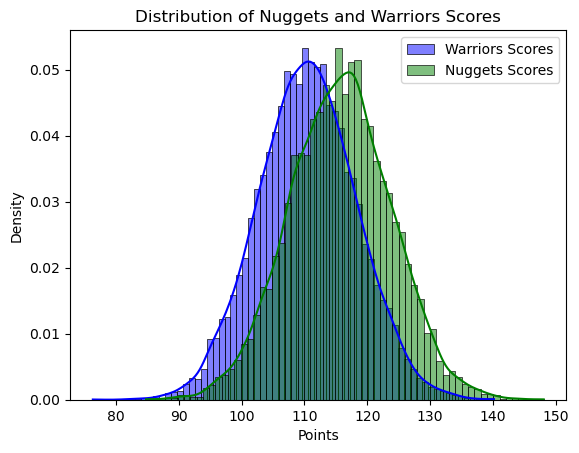

In [44]:
# number of bootstrap samples
num_samples = 10000

# mean and standard deviation for the normal distribution
mean_randomization_factor = 1.0
std_dev_randomization_factor = 0.07

# simulate bootstrap samples
home_scores = np.zeros(num_samples)
away_scores = np.zeros(num_samples)

# calculate win percentage
for i in range(num_samples):
    # sample randomization factors from a normal distribution
    randomization_factor_home = np.random.normal(mean_randomization_factor, std_dev_randomization_factor)
    randomization_factor_away = np.random.normal(mean_randomization_factor, std_dev_randomization_factor)

    # calculate each team's score
    home_score = predicted_home_score * randomization_factor_home
    away_score = predicted_away_score * randomization_factor_away

    # store sampled scores
    home_scores[i] = home_score
    away_scores[i] = away_score

# calculate win percentage
win_percentage_home = np.sum(home_scores > away_scores) / num_samples * 100

# use np.mean directly instead of creating sets
home_score = np.mean(home_scores)
away_score = np.mean(away_scores)

# calculate win percentages for home and away teams
win_percentage_home = np.sum(home_scores > away_scores) / num_samples * 100
win_percentage_away = 100 - win_percentage_home  # Calculate the win percentage for the away team

# determine the team with the higher win percentage
better_team = home_team if win_percentage_home > win_percentage_away else away_team
worse_team = away_team if win_percentage_home > win_percentage_away else home_team

# determine the higher win percentage
higher_win_percentage = max(win_percentage_home, win_percentage_away)

# assign scores to winning and losing teams
better_team_score = home_score if win_percentage_home > win_percentage_away else away_score
worse_team_score = away_score if win_percentage_home > win_percentage_away else home_score

# print results
print(f"Simulated {num_samples} bootstrap samples:")
print(f"\nFinal Score: {better_team_score:.0f}-{worse_team_score:.0f} {better_team}")
print(f"The {better_team} have a higher score than the {worse_team} in {higher_win_percentage:.2f}% of the bootstraped samples.")
print(f"On average, the {better_team} score {better_team_score:.2f} points, while the {worse_team} score {worse_team_score:.2f} points.")

# calculate the lower and upper bounds for the middle 90%
lower_bound_home = np.percentile(home_scores, 5)
upper_bound_home = np.percentile(home_scores, 95)

lower_bound_away = np.percentile(away_scores, 5)
upper_bound_away = np.percentile(away_scores, 95)

# print the range of scores for the middle 90%
print(f"\nIn 90% of the samples, the {home_team} score between {lower_bound_home:.2f} and {upper_bound_home:.2f} points.")
print(f"In 90% of the samples, the {away_team} score between {lower_bound_away:.2f} and {upper_bound_away:.2f} points.\n")

# plot side-by-side bell curves for home and away scores
sns.histplot(home_scores, kde=True, stat="density", color="blue", label=f"{home_team} Scores")
sns.histplot(away_scores, kde=True, stat="density", color="green", label=f"{away_team} Scores")
plt.title(f"Distribution of {better_team} and {worse_team} Scores")
plt.xlabel("Points")
plt.ylabel("Density")
plt.legend()
plt.show()